In [1]:
import ROOT

Welcome to JupyROOT 6.20/02


In [3]:
df_read = ROOT.RDataFrame("Events", "data/mWPilot/ZJToMuMu_mWPilot_TuneCP5_13TeV-powheg-MiNNLO-pythia8-photos_NanoGen_1.root")

In [4]:
tmpdf = df_read.Define("pmu1", "ROOT::Math::PtEtaPhiMVector(LHEPart_pt[0], LHEPart_eta[0], LHEPart_phi[0], LHEPart_mass[0])")
tmpdf = tmpdf.Define("pmu2", "ROOT::Math::PtEtaPhiMVector(LHEPart_pt[1], LHEPart_eta[1], LHEPart_phi[1], LHEPart_mass[1])")

Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available
Warning in <TClass::Init>: no dictionary for class __pair_base<edm::Hash<1>,edm::ParameterSetBlob> is available


In [5]:
newdf = tmpdf.Define("pZ", "pmu1+pmu2")

In [6]:
dfz = newdf.Define("ptZ", "pZ.Pt()")
dfz = dfz.Define("yZ", "pZ.Rapidity()")
dfz = dfz.Define("absyZ", "fabs(pZ.Rapidity())")
dfz = dfz.Define("phiZ", "pZ.Phi()")

In [7]:
hist = dfz.Histo1D("yZ")

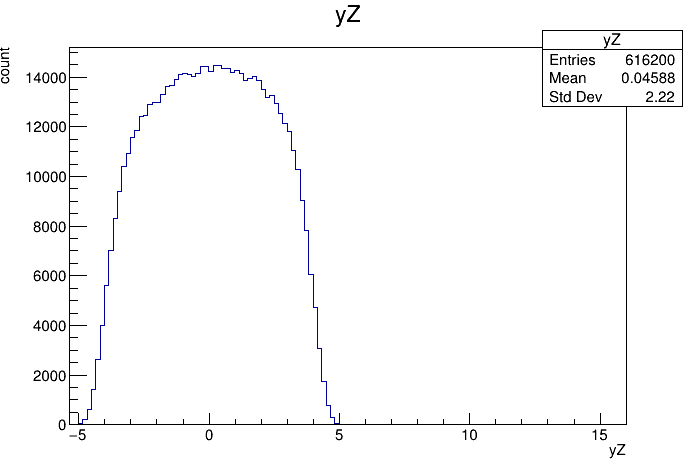

In [8]:
c = ROOT.TCanvas("canvas")
hist.Draw("hist")
c.Draw()

In [ ]:
var_wy  = 'absyZ'
var_wpt = 'ptZ'
var_cos = 'prefsrw_costcs'
var_phi = 'prefsrw_phics'

In [2]:
ROOT.gInterpreter.Declare("""
std::pair<TVector3, TVector3> csBoostedProtons(TLorentzVector dilepton) {
    float protonMass = 0.938272;
    float energy = 6500;
    int zsign = dilepton.Z() > 0 ? 1 : -1;
    TLorentzVector proton1(0., 0., zsign*energy, hypot(energy, protonMass));
    TLorentzVector proton2(0., 0., -1*zsign*energy, hypot(energy, protonMass));
    proton1.Boost(-1*dilepton.BoostVector());
    proton2.Boost(-1*dilepton.BoostVector());
    return std::make_pair<TVector3, TVector3>(proton1.Vect(), proton2.Vect());
}

const TVector3 csframe(TLorentzVector dilepton) {
    std::pair<TVector3, TVector3> protons = csBoostedProtons(dilepton);
    TVector3 csAxis = (protons.first.Unit() - protons.second.Unit()).Unit();
    return csAxis;
}

const TVector3 csframeY(TLorentzVector dilepton) {
    std::pair<TVector3, TVector3> protons = csBoostedProtons(dilepton);
    TVector3 csYAxis = protons.first.Unit().Cross(protons.second.Unit());
    return csYAxis.Unit();
}

const TVector3 csframeX(TLorentzVector dilepton) {
    TVector3 csAxis = csframe(dilepton);
    TVector3 csYAxis = csframeY(dilepton);
    TVector3 csXAxis = csYAxis.Cross(csAxis);
    return csXAxis.Unit();
}

float cosThetaCS(ROOT::Math::PtEtaPhiMVector lplus, ROOT::Math::PtEtaPhiMVector lminus) {
    ROOT::Math::PtEtaPhiMVector dilepton = lplus + lminus;
    TLorentzVector dilep(dilepton.X(), dilepton.Y(), dilepton.Z(), dilepton.T());
    TLorentzVector boostedLep(lplus.X(), lplus.Y(), lplus.Z(), lplus.T());
    boostedLep.Boost(-1*dilep.BoostVector());
    const TVector3 csFrame = csframe(dilep);
    return cos(boostedLep.Angle(csFrame));
}

float phiCS(ROOT::Math::PtEtaPhiMVector lplus, ROOT::Math::PtEtaPhiMVector lminus) {
    ROOT::Math::PtEtaPhiMVector dilepton = lplus + lminus;
    TLorentzVector dilep(dilepton.X(), dilepton.Y(), dilepton.Z(), dilepton.T());
    TLorentzVector boostedLep(lplus.X(), lplus.Y(), lplus.Z(), lplus.T());
    boostedLep.Boost(-1*dilep.BoostVector());
    const TVector3 csFrameX = csframeX(dilep);
    const TVector3 csFrameY = csframeY(dilep);
    float phi = atan2(boostedLep.Vect()*csFrameY, boostedLep.Vect()*csFrameX);
    return phi >= 0 ? phi : phi + 2*M_PI;
}
""")

True

In [10]:
tmpdf2 = dfz.Define("pmup", "LHEPart_pdgId[0] < 0 ? pmu1 : pmu2")
tmpdf2 = tmpdf2.Define("pmum", "LHEPart_pdgId[0] > 0 ? pmu1 : pmu2")
tmpdf2 = tmpdf2.Define("pmumpt", "pmum.Pt()")

In [11]:
dfcs = tmpdf2.Define("costCS", "cosThetaCS(pmup, pmum)")
dfcs = dfcs.Define("phics", "phiCS(pmup, pmum)")

In [18]:
histcs = dfcs.Histo1D("costCS")

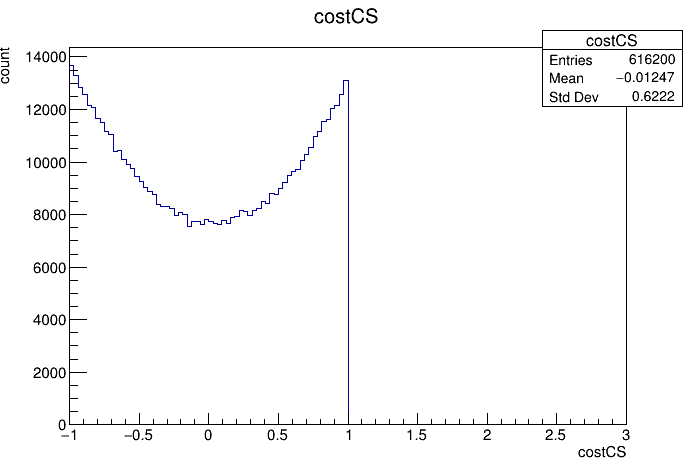

In [19]:
canvas = ROOT.TCanvas("canvas")
histcs.Draw()
canvas.Draw()

In [20]:
histcs = dfcs.Histo1D("phics")

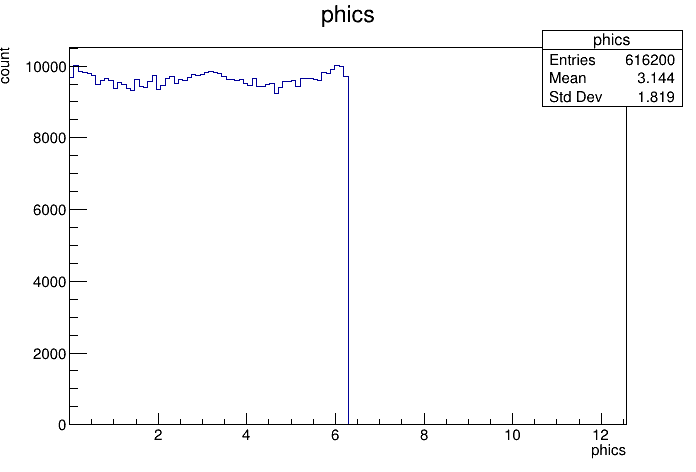

In [21]:
canvas = ROOT.TCanvas("canvas")
histcs.Draw()
canvas.Draw()